## Author

Chandreen Liyanage  
Machine Learning & Data Analytics Enthusiast  


===========================================
## 1)Environment Setup
============================================


In [115]:
# This notebook is designed to run in Google Colab with data stored in Google Drive

from google.colab import drive
import os

import numpy as np
import pandas as pd

#Data preprocessing (encoding + imbalance handling)
from sklearn.preprocessing import OrdinalEncoder
from imblearn.over_sampling import SMOTENC

#Visualization (EDA + reporting)
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from plotly.subplots import make_subplots

#Feature selection (univariate filtering)
from sklearn.feature_selection import SelectKBest, f_classif, mutual_info_classif

# Model development
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV, cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

# Model evaluation
from sklearn.metrics import roc_auc_score, roc_curve, ConfusionMatrixDisplay, classification_report

# Reproducibility: keep random state constant across splits/resampling/models
RANDOM_STATE = 42


In [116]:
# ============================================================
#Mount Drive + define project paths
# ============================================================
drive.mount('/content/drive')

# Project folder structure (keeps outputs like plots in one place)
BASE_PATH = "/content/drive/MyDrive/GithubProjects/icu_mortality"
DATA_PATH = os.path.join(BASE_PATH, "data")
RESULTS_PATH = os.path.join(BASE_PATH, "results")

# Create folders if they do not exist
os.makedirs(DATA_PATH, exist_ok=True)
os.makedirs(RESULTS_PATH, exist_ok=True)

print("BASE_PATH:", BASE_PATH)
print("DATA_PATH:", DATA_PATH)
print("RESULTS_PATH:", RESULTS_PATH)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
BASE_PATH: /content/drive/MyDrive/GithubProjects/icu_mortality
DATA_PATH: /content/drive/MyDrive/GithubProjects/icu_mortality/data
RESULTS_PATH: /content/drive/MyDrive/GithubProjects/icu_mortality/results


========================================================

##2) Load dataset + basic cleaning and checks

========================================================

In [117]:
data_file = os.path.join(DATA_PATH, "dataset.csv")
data = pd.read_csv(data_file)
data.head()

,encounter_id,patient_id,hospital_id,age,bmi,elective_surgery,ethnicity,gender,icu_admit_source,icu_id,...,apache_4a_icu_death_prob,aids,cirrhosis,hepatic_failure,immunosuppression,leukemia,lymphoma,solid_tumor_with_metastasis,apache_2_bodysystem,hospital_death
0,66154,25312,118,68.0,22.73,0,Caucasian,M,Floor,92,...,0.05,0,0,0,0,0,0,0,Cardiovascular,0
1,114252,59342,81,77.0,27.42,0,Caucasian,F,Floor,90,...,0.29,0,0,0,0,0,0,0,Respiratory,0
2,33181,74489,83,67.0,27.56,0,Caucasian,M,Accident & Emergency,95,...,0.02,0,0,0,0,0,0,0,Neurologic,0
3,82208,49526,83,59.0,57.45,0,Caucasian,F,Accident & Emergency,95,...,0.05,0,0,0,0,0,0,0,Respiratory,0
4,120677,124688,118,78.0,NaN,0,Caucasian,F,Accident & Emergency,97,...,0.01,0,0,0,0,0,0,0,Cardiovascular,0


In [118]:
print("Shape:", data.shape)

Shape: (20492, 37)


In [119]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20492 entries, 0 to 20491
Data columns (total 37 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   encounter_id                   20492 non-null  int64  
 1   patient_id                     20492 non-null  int64  
 2   hospital_id                    20492 non-null  int64  
 3   age                            19999 non-null  float64
 4   bmi                            19739 non-null  float64
 5   elective_surgery               20492 non-null  int64  
 6   ethnicity                      20299 non-null  object 
 7   gender                         20491 non-null  object 
 8   icu_admit_source               20468 non-null  object 
 9   icu_id                         20492 non-null  int64  
 10  icu_stay_type                  20492 non-null  object 
 11  icu_type                       20492 non-null  object 
 12  pre_icu_los_days               20492 non-null 

In [120]:
# Remove non-informative identifier columns
# Identifier columns are dropped because they do not carry predictive signal and may introduce noise

id_cols = ['hospital_id', 'patient_id', 'encounter_id', 'icu_id']
id_cols = [c for c in id_cols if c in data.columns]

data = data.drop(columns=id_cols, errors='ignore')

print("Shape after dropping ID columns:", data.shape)


Shape after dropping ID columns: (20492, 33)


============================================================
## 3)Exploratory Data Analysis (EDA)
============================================================

EDA focuses on:
- Missingness patterns
- Target imbalance
- Distributions of key numeric variables
- Correlations
- Mortality trends by ICU admission source and by age & gender

,0
apache_4a_hospital_death_prob,1704
apache_4a_icu_death_prob,1704
d1_potassium_min,1577
d1_potassium_max,1577
bmi,753
d1_temp_min,572
d1_temp_max,572
age,493
d1_glucose_max,390
d1_glucose_min,390


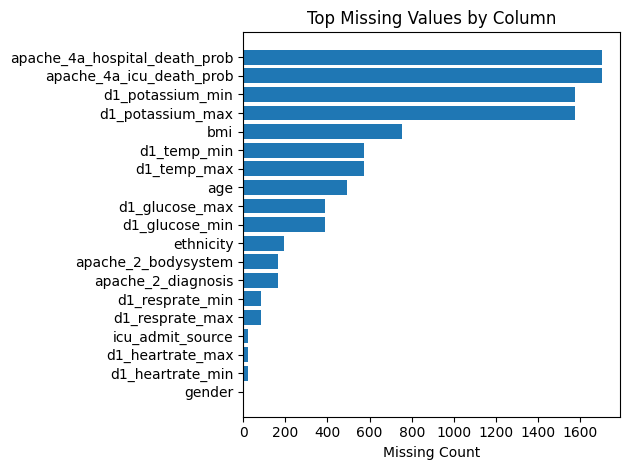

In [121]:
# ------------------------------------------------------------
# Missing value analysis
# ------------------------------------------------------------
# Identify columns with the highest number of missing values
missing = data.isna().sum().sort_values(ascending=False)
display(missing.head(20))

# Visualize top missing columns to guide preprocessing
top_missing = missing[missing > 0].head(20)
plt.figure()
plt.barh(top_missing.index[::-1], top_missing.values[::-1])
plt.title("Top Missing Values by Column")
plt.xlabel("Missing Count")
plt.tight_layout()
plt.savefig(os.path.join(RESULTS_PATH, "eda_missing_values_top20.png"), dpi=300)
plt.show()


Target counts:
 hospital_death
0    18897
1     1595
Name: count, dtype: int64

Target proportions:
 hospital_death
0    0.922165
1    0.077835
Name: proportion, dtype: float64


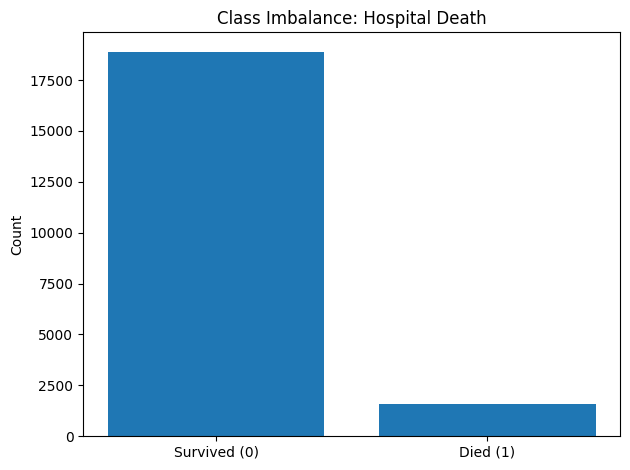

In [122]:
#------------------------------------------------------------
#Target variable distribution (class imbalance)
#------------------------------------------------------------
TARGET = "hospital_death"
assert TARGET in data.columns, f"Target column '{TARGET}' not found."

print("Target counts:\n", data[TARGET].value_counts())
print("\nTarget proportions:\n", data[TARGET].value_counts(normalize=True))



#Visualize imbalance to justify imbalance-handling techniques
counts = data[TARGET].value_counts()
plt.figure()
plt.bar(["Survived (0)", "Died (1)"], [counts.get(0, 0), counts.get(1, 0)])
plt.title("Class Imbalance: Hospital Death")
plt.ylabel("Count")
plt.tight_layout()
plt.savefig(os.path.join(RESULTS_PATH, "eda_target_imbalance.png"), dpi=300)
plt.show()


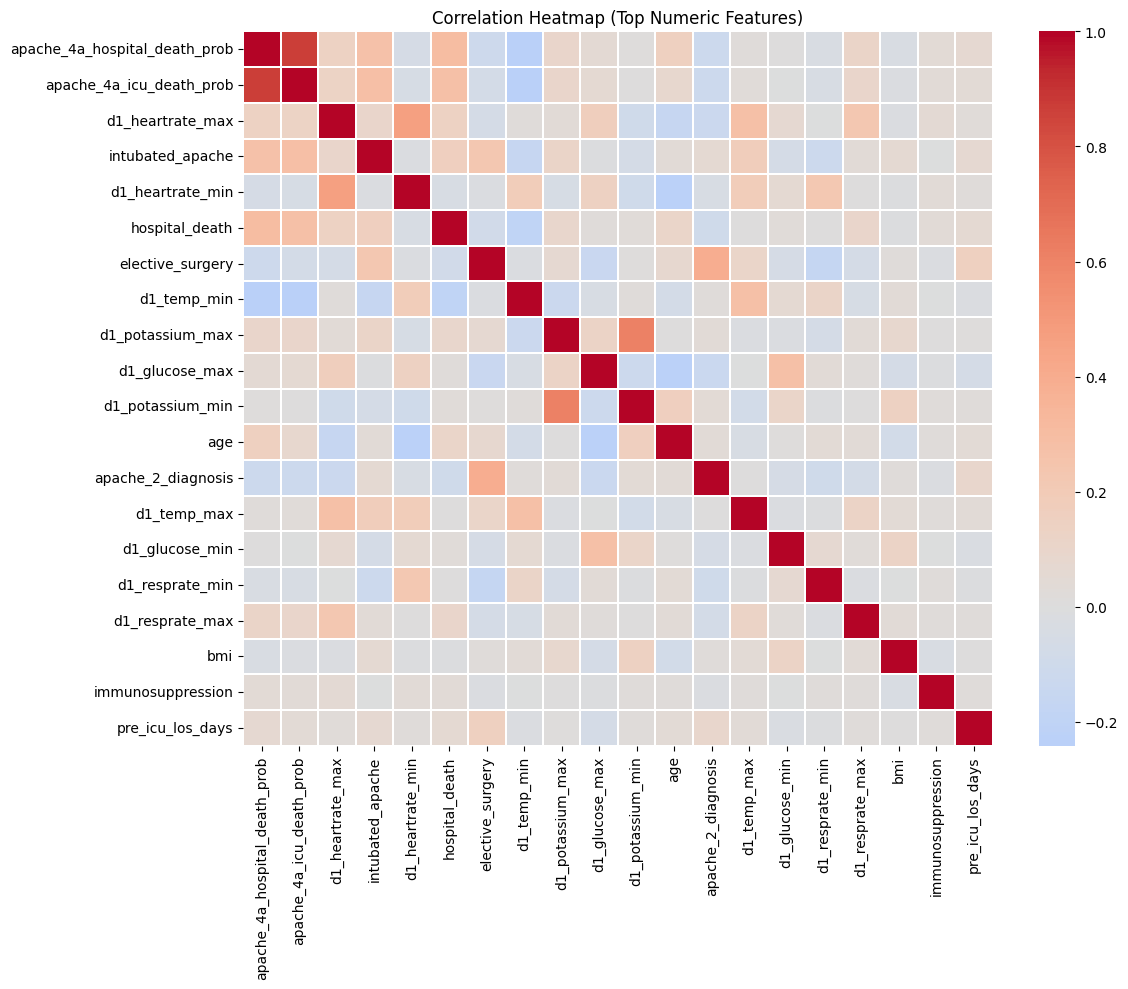

In [123]:
#------------------------------------------------------------
# Correlation analysis
#------------------------------------------------------------
#Correlations are computed for numeric features to identify

numeric_df = data.select_dtypes(include=[np.number]).copy()
corr = numeric_df.corr().abs()

#Plot only top correlated features for readability
top_n = 20
top_features = corr.sum().sort_values(ascending=False).head(top_n).index

plt.figure(figsize=(12, 10))
sns.heatmap(
    numeric_df[top_features].corr(),
    cmap="coolwarm",
    center=0,
    annot=False,
    linewidths=0.3
)
plt.title("Correlation Heatmap (Top Numeric Features)")
plt.tight_layout()
plt.savefig(os.path.join(RESULTS_PATH, "eda_corr_heatmap.png"), dpi=300)
plt.show()



Correlation Analysis Notes

For exploratory purposes, correlation analysis is performed without removing
identifier or high-missingness columns. Only the most strongly correlated
numeric variables are visualized, which naturally excludes non-informative
identifier columns. Formal feature filtering and missing-value handling are
performed later during data preprocessing prior to model development.


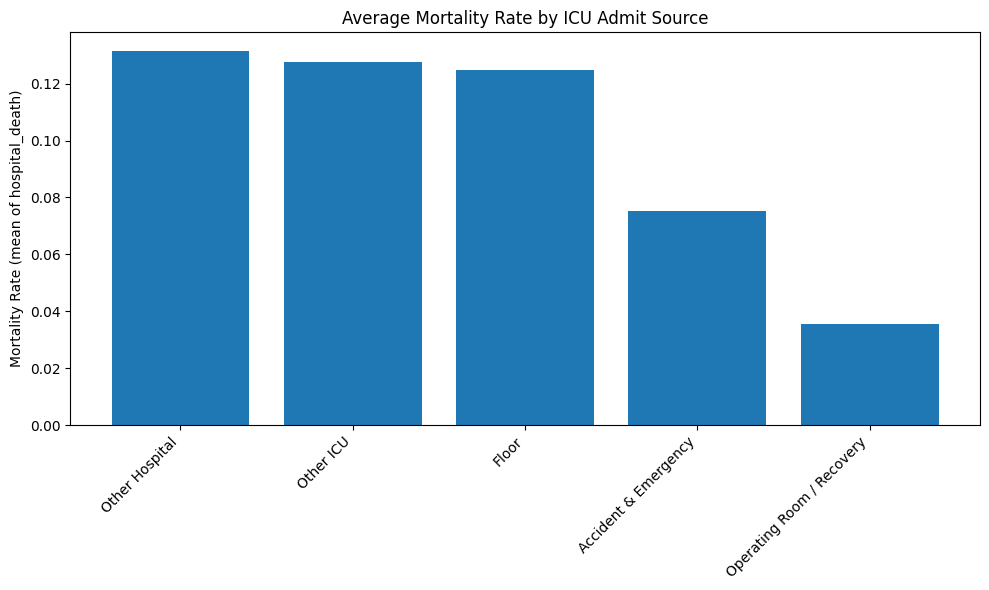

In [124]:
# ------------------------------------------------------------
#Mortality rate by ICU admission source (descriptive analysis)
# ------------------------------------------------------------

source_col = "icu_admit_source"
if source_col in data.columns:
    tmp = data[[source_col, TARGET]].dropna()
    death_rate = tmp.groupby(source_col)[TARGET].mean().sort_values(ascending=False)

    plt.figure(figsize=(10, 6))
    plt.bar(death_rate.index.astype(str), death_rate.values)
    plt.title("Average Mortality Rate by ICU Admit Source")
    plt.ylabel("Mortality Rate (mean of hospital_death)")
    plt.xticks(rotation=45, ha="right")
    plt.tight_layout()
    plt.savefig(os.path.join(RESULTS_PATH, "eda_mortality_by_icu_admit_source.png"), dpi=300)
    plt.show()
else:
    print(f"'{source_col}' not found in dataset. Skipping this EDA chart.")


In [125]:
# ------------------------------------------------------------
#Age-binned mortality by gender
#------------------------------------------------------------
#Age bins are created only for visualization and are not used in modeling.

age_bin = pd.cut(data["age"], bins=10)

age_death = (
    data.assign(age_bin=age_bin)
        .groupby(["age_bin", "gender"], observed=True)["hospital_death"]
        .mean()
        .reset_index()
)

fig = make_subplots()

for g in ["F", "M"]:
    tmp = age_death[age_death["gender"] == g]
    fig.add_trace(
        go.Scatter(
            x=tmp["age_bin"].astype(str),
            y=tmp["hospital_death"],
            name=f"{g} patients"
        )
    )

fig.update_xaxes(title_text="Age group")
fig.update_yaxes(title_text="Average hospital death (unadjusted)")
fig.update_layout(title_text="Unadjusted average hospital death by age group and gender")
fig.show()

=======================================
## 4) Data Preprocessing
=======================================

This section prepares the dataset for modeling by handling missing values, and encoding categorical features.

In [126]:
# ------------------------------------------------------------
#Separate target and features (prevents accidental target leakage)
# ---------------------------------------------------------------------

TARGET = "hospital_death"
X = data.drop(columns=[TARGET])
y = data[TARGET].astype(int)


In [127]:
X

,age,bmi,elective_surgery,ethnicity,gender,icu_admit_source,icu_stay_type,icu_type,pre_icu_los_days,apache_2_diagnosis,...,apache_4a_hospital_death_prob,apache_4a_icu_death_prob,aids,cirrhosis,hepatic_failure,immunosuppression,leukemia,lymphoma,solid_tumor_with_metastasis,apache_2_bodysystem
0,68.0,22.730000,0,Caucasian,M,Floor,admit,CTICU,0.541667,113.0,...,0.10,0.05,0,0,0,0,0,0,0,Cardiovascular
1,77.0,27.420000,0,Caucasian,F,Floor,admit,Med-Surg ICU,0.927778,108.0,...,0.47,0.29,0,0,0,0,0,0,0,Respiratory
2,67.0,27.560000,0,Caucasian,M,Accident & Emergency,admit,Med-Surg ICU,0.000694,301.0,...,0.05,0.02,0,0,0,0,0,0,0,Neurologic
3,59.0,57.450000,0,Caucasian,F,Accident & Emergency,admit,Med-Surg ICU,0.000694,108.0,...,0.10,0.05,0,0,0,0,0,0,0,Respiratory
4,78.0,NaN,0,Caucasian,F,Accident & Emergency,admit,MICU,0.000694,113.0,...,0.02,0.01,0,0,0,0,0,0,0,Cardiovascular
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20487,21.0,24.874059,0,Caucasian,M,Accident & Emergency,admit,Med-Surg ICU,0.052083,123.0,...,0.01,0.00,0,0,0,0,0,0,0,Metabolic
20488,53.0,45.935203,0,Caucasian,M,Accident & Emergency,admit,Med-Surg ICU,0.097917,113.0,...,0.03,0.01,0,0,0,0,0,0,0,Cardiovascular
20489,67.0,28.876843,0,African American,M,Accident & Emergency,admit,Med-Surg ICU,0.213194,123.0,...,0.01,0.00,0,0,0,0,0,0,0,Metabolic
20490,75.0,23.060250,0,Caucasian,M,Floor,admit,Cardiac ICU,0.298611,113.0,...,0.12,0.05,0,0,0,0,0,0,1,Cardiovascular


In [128]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20492 entries, 0 to 20491
Data columns (total 32 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   age                            19999 non-null  float64
 1   bmi                            19739 non-null  float64
 2   elective_surgery               20492 non-null  int64  
 3   ethnicity                      20299 non-null  object 
 4   gender                         20491 non-null  object 
 5   icu_admit_source               20468 non-null  object 
 6   icu_stay_type                  20492 non-null  object 
 7   icu_type                       20492 non-null  object 
 8   pre_icu_los_days               20492 non-null  float64
 9   apache_2_diagnosis             20328 non-null  float64
 10  arf_apache                     20492 non-null  int64  
 11  intubated_apache               20492 non-null  int64  
 12  d1_heartrate_max               20471 non-null 

In [129]:
# ------------------------------------------------------------
#Identify categorical vs numeric features
# -----------------------------------------------------

cat_cols = X.select_dtypes(include=["object", "category", "bool"]).columns.tolist()
num_cols = [c for c in X.columns if c not in cat_cols]

print("Categorical features:", len(cat_cols))
print("Numeric features:", len(num_cols))


Categorical features: 6
Numeric features: 26


Missing-value policy:
- Drop features with very high missingness
- Add a missingness flag for moderately missing features
- Impute the rest (mode for categorical, mean for numeric)

In [130]:
missing_ratio = X.isna().mean()

# Drop columns with very high missingness (>30%)
high_missing_cols = missing_ratio[missing_ratio > 0.30].index.tolist()
data_prep_missing = X.drop(columns=high_missing_cols, errors="ignore").copy()

print("Dropped high-missing cols:", len(high_missing_cols))
print("Shape after drop:", data_prep_missing.shape)

Dropped high-missing cols: 0
Shape after drop: (20492, 32)


In [131]:
#Add missingness indicators for moderately missing features (5%–30%)
flag_cols = missing_ratio[(missing_ratio > 0.05) & (missing_ratio <= 0.30)].index.tolist()

for c in flag_cols:
    # 1 = originally missing, 0 = originally present (preserves missingness signal)
    if c in data_prep_missing.columns:
        data_prep_missing[f"{c}_missing"] = data_prep_missing[c].isna().astype(int)

# IMPORTANT: update column lists after dropping columns
cat_cols = [c for c in cat_cols if c in data_prep_missing.columns]
num_cols = [c for c in num_cols if c in data_prep_missing.columns]

In [132]:
print(data_prep_missing.shape)

(20492, 36)


In [133]:
# Impute categorical features with mode (most frequent category)
if cat_cols:
    data_prep_missing[cat_cols] = data_prep_missing[cat_cols].fillna(
        data_prep_missing[cat_cols].mode().iloc[0]
    )

# Impute numeric features with mean
data_prep_missing[num_cols] = data_prep_missing[num_cols].fillna(
    data_prep_missing[num_cols].mean()
)

print("Remaining missing values:", int(data_prep_missing.isna().sum().sum()))

Remaining missing values: 0


In [134]:
# checking for NULL values in the dataset
data_prep_missing.isna().any()

,0
age,False
bmi,False
elective_surgery,False
ethnicity,False
gender,False
icu_admit_source,False
icu_stay_type,False
icu_type,False
pre_icu_los_days,False
apache_2_diagnosis,False


Encode categorical features (SMOTENC-compatible)

In [135]:
data_prep_enc = data_prep_missing.copy()

if cat_cols:
    encoder = OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-1)
    data_prep_enc[cat_cols] = encoder.fit_transform(data_prep_enc[cat_cols])



In [136]:
#Save categorical feature indices for SMOTENC (based on encoded X columns)
categorical_idx = [data_prep_enc.columns.get_loc(c) for c in cat_cols]
print("Categorical feature indices for SMOTENC:", categorical_idx)

Categorical feature indices for SMOTENC: [3, 4, 5, 6, 7, 31]


In [137]:
data_prep_enc.shape

(20492, 36)

Check target column

In [138]:
# Target should be 0/1 ints, with no missing values
assert y.isna().sum() == 0
y = y.astype(int)
print(y.value_counts())


hospital_death
0    18897
1     1595
Name: count, dtype: int64


======================================
# 5) Model Development
=======================================

This section builds and evaluates ML models to predict hospital mortality.
Key practices:
- stratified split to preserve class imbalance in train/test
- SMOTENC applied ONLY on training data (prevents data leakage)
- SelectKBest fitted ONLY on training data (prevents data leakage)
- evaluation using ROC AUC (appropriate for imbalanced classification)

In [139]:
#Split train and test sets
X_train, X_test, y_train, y_test = train_test_split(
    data_prep_enc,
    y,
    test_size=0.30,
    random_state=RANDOM_STATE,
    stratify=y  #preserve class ratio in both splits
)

print("Train target distribution:\n", y_train.value_counts(normalize=True))
print("Test target distribution:\n", y_test.value_counts(normalize=True))

print("Train target distribution:\n", y_train.value_counts())
print("Test target distribution:\n", y_test.value_counts())

Train target distribution:
 hospital_death
0    0.922197
1    0.077803
Name: proportion, dtype: float64
Test target distribution:
 hospital_death
0    0.922088
1    0.077912
Name: proportion, dtype: float64
Train target distribution:
 hospital_death
0    13228
1     1116
Name: count, dtype: int64
Test target distribution:
 hospital_death
0    5669
1     479
Name: count, dtype: int64


Handle class imbalance using SMOTENC

SMOTENC is used because the dataset contains a mix of categorical and numeric features.
IMPORTANT: resampling is applied only to the training set to avoid leaking information into the test set.

In [140]:
smote = SMOTENC(
    categorical_features=categorical_idx,
    random_state=RANDOM_STATE
)

X_train_bal, y_train_bal = smote.fit_resample(X_train, y_train)

print("Before SMOTENC:\n", y_train.value_counts())
print("After SMOTENC:\n", y_train_bal.value_counts())

Before SMOTENC:
 hospital_death
0    13228
1     1116
Name: count, dtype: int64
After SMOTENC:
 hospital_death
0    13228
1    13228
Name: count, dtype: int64


In [141]:
#Verify whether X and y (features and target) has the same number of records in both training and testing sets.
assert X_train_bal.shape[0] == y_train_bal.shape[0]
assert X_test.shape[0] == y_test.shape[0]


Feature selection (SelectKBest)

In [142]:
#Get best 28 features
K = 28

selector = SelectKBest(score_func=f_classif, k=K)
X_train_fs = selector.fit_transform(X_train_bal, y_train_bal)
#transform x_text to keep the feature list same as the train set
X_test_fs  = selector.transform(X_test)

selected_mask = selector.get_support()
selected_features = data_prep_enc.columns[selected_mask].tolist()

print("Selected feature count:", len(selected_features))
print("Top selected features (first 15):", selected_features[:15])


Selected feature count: 28
Top selected features (first 15): ['age', 'bmi', 'elective_surgery', 'gender', 'icu_admit_source', 'icu_stay_type', 'icu_type', 'pre_icu_los_days', 'apache_2_diagnosis', 'arf_apache', 'd1_heartrate_max', 'd1_heartrate_min', 'd1_resprate_max', 'd1_temp_min', 'd1_glucose_max']


In [143]:
#save feature scores for interpretation
fs_scores = pd.DataFrame({
    "feature": data_prep_enc.columns,
    "score": selector.scores_
}).sort_values("score", ascending=False)

fs_scores.head(15)


,feature,score
22,apache_4a_hospital_death_prob,6619.091640
23,apache_4a_icu_death_prob,5420.453130
17,d1_temp_min,1963.950263
31,apache_2_bodysystem,1846.979036
2,elective_surgery,1679.048187
12,d1_heartrate_max,1373.610300
0,age,1317.742332
35,apache_4a_icu_death_prob_missing,940.299245
34,apache_4a_hospital_death_prob_missing,940.299245
9,apache_2_diagnosis,931.691417


Extra knowledge about how to select the score function

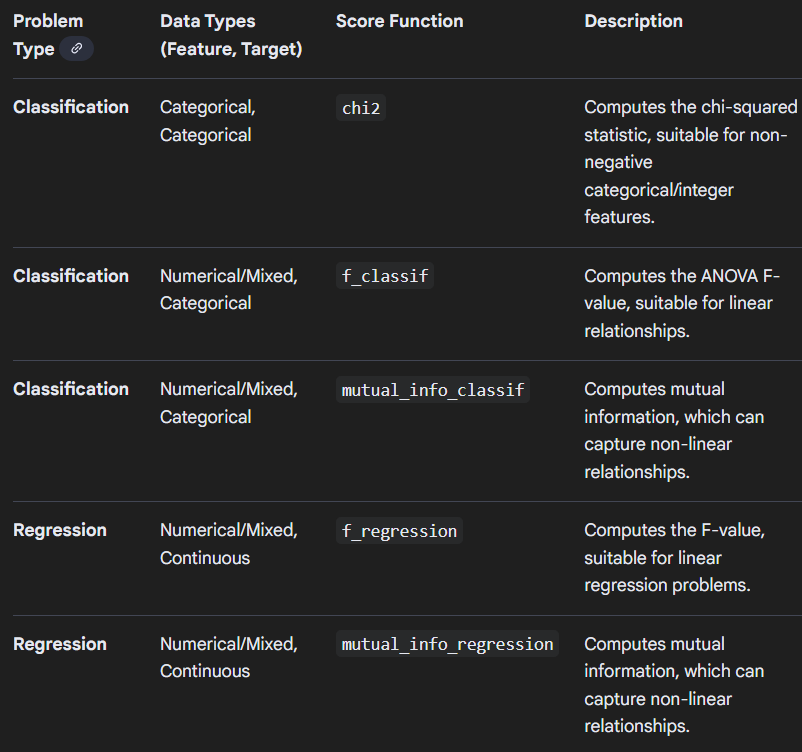

Train and evaluate models (ROC AUC + CV)

In [144]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)
#CV is computed on training data only (used for comparison, not final reporting)

def eval_model(name, model, Xtr, ytr, Xte, yte):
    #CV roc_auc gives a quick stability check. Final ROC AUC is reported on the test set.
    cv_auc = cross_val_score(model, Xtr, ytr, cv=cv, scoring="roc_auc").mean()


    model.fit(Xtr, ytr)
    proba = model.predict_proba(Xte)[:, 1]
    auc = roc_auc_score(yte, proba)

    preds = (proba >= 0.5).astype(int)  # default decision threshold
    print(f"\n{name} | CV ROC AUC: {cv_auc:.3f} | Test ROC AUC: {auc:.3f}")
    print(classification_report(yte, preds))

    return model, proba, auc, cv_auc

In [145]:
models = {
    "KNN": KNeighborsClassifier(n_neighbors=6),
    "Decision Tree": DecisionTreeClassifier(random_state=RANDOM_STATE),
    "Random Forest": RandomForestClassifier(n_estimators=500, random_state=RANDOM_STATE)
}

In [146]:
results = []
trained = {}

for name, model in models.items():
    m, proba, auc, cv_auc = eval_model(name, model, X_train_fs, y_train_bal, X_test_fs, y_test)
    trained[name] = (m, proba)
    results.append((name, auc, cv_auc))

pd.DataFrame(results, columns=["Model", "Test_ROC_AUC", "CV_ROC_AUC"]).sort_values("Test_ROC_AUC", ascending=False)



KNN | CV ROC AUC: 0.952 | Test ROC AUC: 0.602
              precision    recall  f1-score   support

           0       0.94      0.68      0.79      5669
           1       0.11      0.47      0.18       479

    accuracy                           0.66      6148
   macro avg       0.52      0.57      0.48      6148
weighted avg       0.87      0.66      0.74      6148


Decision Tree | CV ROC AUC: 0.918 | Test ROC AUC: 0.615
              precision    recall  f1-score   support

           0       0.94      0.91      0.93      5669
           1       0.23      0.32      0.27       479

    accuracy                           0.86      6148
   macro avg       0.59      0.62      0.60      6148
weighted avg       0.89      0.86      0.87      6148


Random Forest | CV ROC AUC: 0.987 | Test ROC AUC: 0.833
              precision    recall  f1-score   support

           0       0.95      0.94      0.94      5669
           1       0.35      0.41      0.38       479

    accuracy         

,Model,Test_ROC_AUC,CV_ROC_AUC
2,Random Forest,0.832643,0.987411
1,Decision Tree,0.615079,0.918053
0,KNN,0.601943,0.952262


Plots for the best model

In [147]:
# Select the best model (based on test ROC AUC from the comparison table above)
best_name = "Random Forest"
best_model, best_proba = trained[best_name]


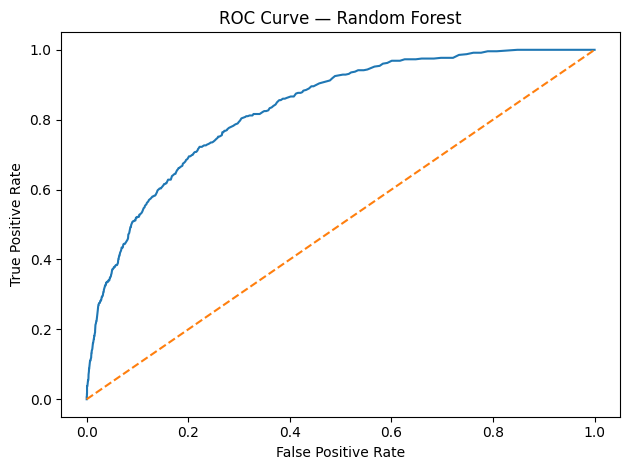

In [148]:
#ROC curve
fpr, tpr, _ = roc_curve(y_test, best_proba)
plt.figure()
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title(f"ROC Curve — {best_name}")
plt.tight_layout()
plt.savefig(os.path.join(RESULTS_PATH, f"roc_curve_{best_name.replace(' ','_').lower()}.png"), dpi=300)
plt.show()



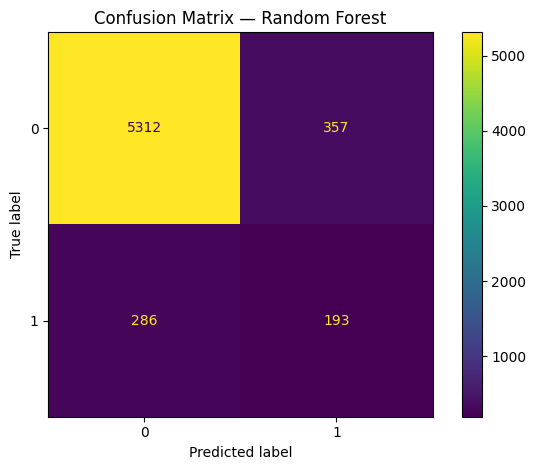

In [149]:
#Confusion matrix
ConfusionMatrixDisplay.from_estimator(best_model, X_test_fs, y_test)
plt.title(f"Confusion Matrix — {best_name}")
plt.tight_layout()
plt.savefig(os.path.join(RESULTS_PATH, f"confusion_matrix_{best_name.replace(' ','_').lower()}.png"), dpi=300)
plt.show()


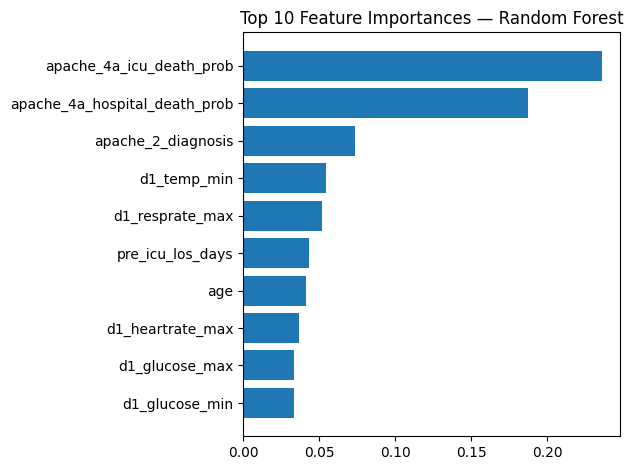

In [150]:
# Feature importance
if hasattr(best_model, "feature_importances_"):

    importances = best_model.feature_importances_
    fi = pd.DataFrame({"feature": selected_features, "importance": importances}) \
            .sort_values("importance", ascending=False).head(10)

    plt.figure()
    plt.barh(fi["feature"][::-1], fi["importance"][::-1])
    plt.title(f"Top 10 Feature Importances — {best_name}")
    plt.tight_layout()
    plt.savefig(os.path.join(RESULTS_PATH, f"feature_importance_{best_name.replace(' ','_').lower()}.png"), dpi=300)
    plt.show()